In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
sys.path.append('../')
sys.path.append('../utils/')
import feedforward_robust as ffr
import ipdb
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

#Read the counter
ctr_file = "counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

W0926 22:33:07.157025 4406191552 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Setup - Dataset stuff
dataset, input_shape, num_classes = get_dataset()
x_train_flat, y_train = dataset[0] 
x_test_flat, y_test = dataset[1] 
hidden_sizes = [32,32,32,32,32,32,32]

In [4]:
x_train_flat.shape

(60000, 784)

In [5]:
scope_list = ["hybrid", "model_non_robust", ]

In [6]:
x_test_2d = [vec.reshape((28,28)) for vec in x_test_flat]

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


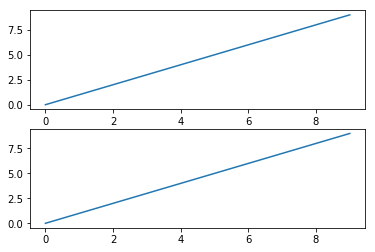

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)


ax1.plot(range(10), range(10))
ax2.plot(range(10), range(10))

fig.show()

### Trying out different corruptions 

In [8]:
#Random trying out stuff
x_test_gaussian_blurred = gaussian_blurring(x_test_2d, 0.5)

In [9]:
x_test_rotated = rotate(x_test_2d, angle = 45)

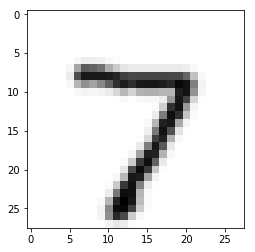

In [10]:
plt.imshow(x_test_gaussian_blurred[0], cmap = plt.cm.binary)

## Regular Training Run Test

In [11]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 222
config['write_counter'] = counter
config['sigma'] = tf.nn.relu
config['epochs'] = 10
config['reg'] = 0.0
config['lr'] = 3e-4

config['scope_name'] = "model_non_robust"
config['should_load'] = False
config['logger'] = logger

In [68]:
tf.reset_default_graph()

In [69]:
#model_hybrid, sess_hybrid, = regular_training(config)
model, sess, path = l1_reg_model_train(counter, logger, 0.0009)

Initialized instance variables of the robust model class
I0927 00:37:10.213084 4406191552 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0927 00:37:10.221186 4406191552 feedforward_robust.py:38] Created placeholders for x and y
Created layers and tensor for logits
I0927 00:37:10.397358 4406191552 feedforward_robust.py:42] Created layers and tensor for logits
Added loss computation to the graph
I0927 00:37:10.425125 4406191552 feedforward_robust.py:47] Added loss computation to the graph
Added accuracy computation to the graph
I0927 00:37:10.432898 4406191552 feedforward_robust.py:51] Added accuracy computation to the graph
Model graph was created
I0927 00:37:10.436273 4406191552 feedforward_robust.py:54] Model graph was created
Created model successfully. Now going to load weights
I0927 00:37:10.443347 4406191552 utils_models.py:48] Created model successfully. Now going to load weights
Epoch: 0001    cost: 1.15783620

I0927 00:38:21.452136 4406191552 feedforward_robust.py:418] Accuracy on batch: 1.000000
Epoch: 0031    cost: 0.581145068 
I0927 00:38:23.725812 4406191552 feedforward_robust.py:417] Epoch: 0031    cost: 0.581145068 
Accuracy on batch: 0.937500
I0927 00:38:23.727741 4406191552 feedforward_robust.py:418] Accuracy on batch: 0.937500
Epoch: 0032    cost: 0.577700119 
I0927 00:38:26.315976 4406191552 feedforward_robust.py:417] Epoch: 0032    cost: 0.577700119 
Accuracy on batch: 1.000000
I0927 00:38:26.317246 4406191552 feedforward_robust.py:418] Accuracy on batch: 1.000000
Epoch: 0033    cost: 0.574506921 
I0927 00:38:28.854799 4406191552 feedforward_robust.py:417] Epoch: 0033    cost: 0.574506921 
Accuracy on batch: 1.000000
I0927 00:38:28.856104 4406191552 feedforward_robust.py:418] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.577398122 
I0927 00:38:31.059686 4406191552 feedforward_robust.py:417] Epoch: 0034    cost: 0.577398122 
Accuracy on batch: 0.968750
I0927 00:38:31.060926 44

In [13]:
aa

NameError: name 'aa' is not defined

# Hybrid Training

In [ ]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter_robust'] = 280
config['load_counter_non_robust'] = 282
config['should_slash'] = False
config['slash_factor'] = 0.70

config['sigma'] = tf.nn.relu

config['scope_name'] = "hybrid"

In [ ]:
model_hybrid, sess_hybrid = hybrid_training(config)

In [ ]:
dphi_dx_test_hybrid = model_hybrid.get_dphi_dx(sess_hybrid, x_test_flat)[0]

In [ ]:
np.mean(np.abs(dphi_dx_test_hybrid))

In [ ]:
dpred_dx_test_hybrid = model_hybrid.get_pred_dx(sess_hybrid, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_hybrid))

## Regular Training

In [ ]:
#tf.reset_default_graph()

In [ ]:
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 222
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [ ]:
config['scope_name']

In [ ]:
model_non_robust, sess_non_robust = regular_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_non_robust = model_non_robust.get_weights_np(sess_non_robust)

In [ ]:
#Original without regularization
sing_vals = []
for (idx, weight_matrix) in enumerate(weights_non_robust):
        sig = plot_singular_values(weight_matrix, idx, "Non robust model")
        sing_vals.append(sig)

In [ ]:
#Regular points
acts = model_non_robust.get_activation(sess_non_robust, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, config['eps_test'])
acts_adv = model_non_robust.get_activation(sess_non_robust, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

In [ ]:
dphi_dx_test = model_non_robust.get_dphi_dx(sess_non_robust, x_test_flat)[0]

In [ ]:
dphi_dx_test[0]

In [ ]:
dphi_dx_test_non_robust = dphi_dx_test
np.mean(np.abs(dphi_dx_test_non_robust))

In [ ]:
dpred_dx_test_non_robust = model_non_robust.get_pred_dx(sess_non_robust, x_test_flat)[0]
np.mean(np.abs(dpred_dx_test_non_robust))

In [ ]:
with tf.variable_scope(config['scope_name'], reuse = tf.AUTO_REUSE) as scope:
    x_test_feat_pert = model_non_robust.attack_featurization_space(sess_non_robust, x_test_flat, y_test, 1.0, 0.1, 200)
    loss_feat_adv, acc_feat_adv = model_non_robust.evaluate_from_featurizations(sess_non_robust, x_test_feat_pert, y_test)
    print(loss_feat_adv, acc_feat_adv)

In [ ]:
adv_images_fgsm = model_non_robust.fgsm_np(sess_non_robust, x_test_flat, y_test, 0.10)

In [ ]:
test_image = adv_images_fgsm[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)

In [ ]:
"""
test_image = adv_images_pgd[0]
two_d = test_image.reshape((28,28))
plt.imshow(two_d, cmap = plt.cm.binary)
"""

## Trace regularization for first layer

In [ ]:
#Config
config = {}
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"

config['load_counter'] = 121
config['sigma'] = tf.nn.relu

config['scope_name'] = "model_non_robust"

In [ ]:
config['scope_name']

In [ ]:
reg_model, sess_reg = regular_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = reg_model.get_weights_np(sess_reg)

In [ ]:
#With regularization
sing_vals_reg = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "First layer penalized")
        sing_vals_reg.append(sig)

**Interpretation** This is pretty interesting. When you penalize the singular values of the first layer, all the other layers start increasing to compensate - I'm guessing to keep the expressiveness high. Probably, if we penalize all the singular values, it may not learn anything?

So we still have not suceeded at replicating the singular value spectrum of the robust model - so it is difficult to conclude whether the singular value spectrum is a determinant of adversarial robustness or not

In [ ]:
#With regularization - first layer
sing_vals_reg

In [ ]:
#Regular points
acts = reg_model.get_activation(sess_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = reg_model.fgsm_np(sess_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = reg_model.get_activation(sess_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

In [ ]:
dphi_dx_robust_first_reg = reg_model.get_dphi_dx(sess_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_first_reg))

In [ ]:
dpred_dx_robust_first_reg = reg_model.get_pred_dx(sess_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_first_reg))

# Trace regularization for all layers

In [ ]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 126
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_non_robust"

In [ ]:
model_all_reg, sess_all_reg = regular_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights = model_all_reg.get_weights_np(sess_all_reg)

In [ ]:
#With regularization
sing_vals_all = []
for (idx, weight_matrix) in enumerate(weights):
        sig = plot_singular_values(weight_matrix, idx, "all layers penalized")
        sing_vals_all.append(sig)

In [ ]:
#Regular points
acts = model_all_reg.get_activation(sess_all_reg, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_all_reg.fgsm_np(sess_all_reg, x_test_flat, y_test, config['eps_test'])
acts_adv = model_all_reg.get_activation(sess_all_reg, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

In [ ]:
dphi_dx_robust_all_reg = reg_model.get_dphi_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dphi_dx_robust_all_reg))

In [ ]:
dpred_dx_robust_all_reg = reg_model.get_pred_dx(sess_all_reg, x_test_flat)
np.mean(np.abs(dpred_dx_robust_all_reg))

# FGSM Adversarial Training

In [ ]:
#Config
config['eps_train'] = 0.1
config['eps_test'] = 0.1
config['tensorboard_dir'] = "tb/"
config['weights_dir'] = "weights/"
config['load_counter'] = 280
config['sigma'] = tf.nn.relu
config['scope_name'] = "model_robust"

In [ ]:
model_rob, sess_rob = adversarial_training(config)

In [ ]:
with tf.variable_scope(config['scope_name']) as scope:
    weights_robust = model_rob.get_weights_np(sess_rob)

In [ ]:
sing_vals_robust = []
for (idx, weight_matrix) in enumerate(weights_robust):
    sig = plot_singular_values(weight_matrix, idx, "FGSM adversarially trained model")
    sing_vals_robust.append(sig)

In [ ]:
dphi_dx_robust = model_rob.get_dphi_dx(sess_rob, x_test_flat)
np.mean(np.abs(dphi_dx_robust))

In [ ]:
dpred_dx_robust = model_rob.get_pred_dx(sess_rob, x_test_flat)
np.mean(np.abs(dpred_dx_robust))

In [ ]:
sing_vals[0]

In [ ]:
sing_vals_robust[0]

In [ ]:
sing_vals[1]

In [ ]:
sing_vals_robust[1]

In [ ]:
sing_vals[2]

In [ ]:
sing_vals_robust[2]

In [ ]:
sing_vals[-1]

In [ ]:
sing_vals_robust[-1]

In [ ]:
#Regular points
acts = model_rob.get_activation(sess_rob, x_test_flat)
diff, diff_norm = activation_distance(acts)

#Adversarial points
x_test_flat_adv = model_rob.fgsm_np(sess_rob, x_test_flat, y_test, config['eps_test'])
acts_adv = model_rob.get_activation(sess_rob, x_test_flat_adv)
diff_adv, diff_norm_adv = activation_distance(acts_adv)

In [ ]:
diff_norm

In [ ]:
diff_norm_adv

# Comparison plots

## Distances

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = 2)

In [ ]:
#make_dist_plot_all_models(model_list, sess_list, scope_list, legend_list, order = float("inf"))

## Stats

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]

In [ ]:
reg_evals, adv_evals, margins, dphi_dxs = get_stats_all_models(model_list, sess_list, scope_list)

In [ ]:
#model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model

In [ ]:
reg_evals

In [ ]:
adv_evals

In [ ]:
dphi_dxs

In [ ]:
margins

In [ ]:
labels = ['non robust', 'Sing val all', 'fgsm train', 'hybrid', 'sing val first']

In [ ]:
adv_evals_np = np.array(adv_evals)
acc_adv = adv_evals_np[:, 1]

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
rects2 = ax.bar(x + width/2, margins, width, label='margin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Margins/ Gradient means')
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
print(adv_evals_np[:, 1])

In [ ]:
x = 2*np.arange(len(labels))  # the label locations
width = 0.60  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, dphi_dxs, width, label='dphi_dx')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Gradient means')
ax.set_ylim((0, 1.1))
ax.set_title('Margins and gradient for diferent models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


color = 'tab:orange'
ax2 = ax.twinx()
rects2 = ax2.bar(x + width/2, margins, width, label='margin', color = color)
ax2.set_ylabel('Margins')
ax2.set_ylim((0, 0.40))
#ax.set_xticks(x)
#ax.set_xticklabels(labels)
#ax2.legend(legend_loc = (1.0, 0.8))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for (idx, rect) in enumerate(rects1):
        height = rect.get_height()
        height_2 = rects2[idx].get_height() * (1.0/0.37)
        height = max(height, height_2)
        ax.annotate('{:0.3f}'.format(acc_adv[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()
print(adv_evals_np[:, 1])

## Accuracies 

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
#make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = False)

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.02, 0.05, 0.1, 0.2, 0.3]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps(model_list, sess_list, eps_list, legend_list, scope_list, pgd = True)

## Black box accuracies

In [ ]:
model_list = [model_non_robust, model_all_reg, model_rob, model_hybrid, reg_model]
sess_list = [sess_non_robust, sess_all_reg, sess_rob, sess_hybrid, sess_reg]
eps_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
angle_list = [10, 15, 20, 25, 30, 35, 40]
scope_list = ["model_non_robust", "model_non_robust", "model_robust", "hybrid", "model_non_robust"]
legend_list = ['non_robust', 'all layers trace reg', 'robust', 'hybrid', 'first layer trace reg']

In [ ]:
make_plot_acc_vs_eps_black_box(model_list, sess_list, eps_list, angle_list, legend_list, scope_list)

## Singular Values 

In [ ]:
norm_factor_non = sing_vals[0][0]
sing_non = sing_vals[0]/norm_factor_non
norm_factor_rob = sing_vals_robust[0][0]
sing_rob = sing_vals_robust[0]/norm_factor_rob

plt.loglog(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.loglog(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.semilogy(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.semilogy(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
plt.plot(range(len(sing_vals[0])), sing_non , label = "non robust")
plt.plot(range(len(sing_vals_robust[0])), sing_rob , label = "robust")
plt.legend(loc = "upper right")

In [ ]:
def all_plots_layer_k(k):
    norm_factor_non = sing_vals[k][0]
    print("-----NORM FACTOR NON---")
    print(norm_factor_non)
    sing_non = sing_vals[k]/norm_factor_non
    norm_factor_rob = sing_vals_robust[k][0]
    print("-----NORM FACTOR ROB---")
    print(norm_factor_rob)
    sing_rob = sing_vals_robust[k]/norm_factor_rob
    plt.loglog(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.loglog(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.semilogy(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.semilogy(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()
    plt.plot(range(len(sing_vals[k])), sing_non , label = "non robust")
    plt.plot(range(len(sing_vals_robust[k])), sing_rob , label = "robust")
    plt.legend(loc = "upper right")
    plt.show()

In [ ]:
num_layers = len(sing_vals)

In [ ]:
num_layers

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")

In [ ]:
for k in range(8):
    print(k)
    print("-----------")
    all_plots_layer_k(k)
    print("-----------")